In [1]:
# IMPORTS GENERALES
import os
from pathlib import Path
import io, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from math import sqrt
from google.colab import files

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats

# Configuración general de gráficos
plt.rcParams.update({
    "figure.figsize": (7, 5),
    "axes.grid": True,
    "axes.titlesize": 12,
    "axes.labelsize": 11
})

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 120)

In [2]:
#CARGA DE ARCHIVOS
uploaded = files.upload()  # seleccioná: base respondieron.xlsx, base norespondieron.xlsx

print("Archivos subidos:", list(uploaded.keys()))
norespondieron = pd.read_excel(list(uploaded.keys())[0])
respondieron = pd.read_excel(list(uploaded.keys())[1])

# Estandarizar nombres de columnas
def clean_cols(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
        .str.replace(r'[^0-9A-Za-z_]+', '', regex=True)
        .str.upper()
    )
    return df

respondieron = clean_cols(respondieron)
norespondieron = clean_cols(norespondieron)

Saving base norespondieron.xlsx to base norespondieron.xlsx
Saving base respondieron.xlsx to base respondieron.xlsx
Archivos subidos: ['base norespondieron.xlsx', 'base respondieron.xlsx']


# VISUALIZANDO BASES

In [3]:
print("Base respondieron")
display(respondieron.head())
display(respondieron.columns)

print("")
print("")

print("Base no resopndieron")
display(norespondieron.head())
display(norespondieron.columns)

Base respondieron


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,P47T,PP04B_COD,PP07A,PP07C,MAS_500,CH03,ANIO,AD_EQUIV_HOGAR3,CBT_AE,INGRESO_NECESARIO,POBRE
0,1,80,4,1,3,3,1,583.0,583,583,,0.0,0.0,S,1,2005,0.74,205.07,151.7518,0
1,1,26,2,4,4,1,0,150.0,450,450,5311,0.0,0.0,S,1,2005,1.78,205.07,365.0246,0
2,2,27,2,4,6,3,4,150.0,450,0,,0.0,0.0,S,2,2005,1.78,205.07,365.0246,0
3,2,-1,5,4,7,4,5,150.0,450,0,,0.0,0.0,S,3,2005,1.78,205.07,365.0246,0
4,2,71,4,1,2,3,1,855.0,855,855,,0.0,0.0,S,1,2005,0.67,205.07,137.3969,0


Index(['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC',
       'IPCF', 'ITF', 'P47T', 'PP04B_COD', 'PP07A', 'PP07C', 'MAS_500', 'CH03',
       'ANIO', 'AD_EQUIV_HOGAR3', 'CBT_AE', 'INGRESO_NECESARIO', 'POBRE'],
      dtype='object')



Base no resopndieron


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,P47T,PP04B_COD,PP07A,PP07C,MAS_500,CH03,ANIO
0,2,39,3,2,5,2,0,0,0,0.0,,0.0,0.0,S,1,2005
1,1,16,5,2,3,3,3,0,0,0.0,,0.0,0.0,S,3,2005
2,2,14,5,2,3,3,3,0,0,0.0,,0.0,0.0,S,3,2005
3,2,8,5,2,1,4,3,0,0,0.0,,0.0,0.0,S,3,2005
4,1,62,1,1,3,3,7,0,0,0.0,,0.0,0.0,S,1,2005


Index(['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC',
       'IPCF', 'ITF', 'P47T', 'PP04B_COD', 'PP07A', 'PP07C', 'MAS_500', 'CH03',
       'ANIO'],
      dtype='object')

A. Enfoque de validación:

Utilicen la base respondieron. Para cada año, dividan las observaciones en una base de prueba (test) y una de entrenamiento (train) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 444. Establezca a pobre como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables seleccionadas serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1) para el intercepto. Aclaración: no incluir la variable ingreso en X para predecir la pobreza porque cuando vayamos a la base de norespondieron no vamos a tener esa información.

1. Cree una tabla de diferencia de medias entre la base de entrenamiento y la de testeo de las características seleccionadas en su matriz X. Para la matriz de las X seleccione variables que hayan limpiado en los TPs anteriores y justifique su inclusión para predecir la pobreza. Comente la tabla de la diferencia de medias de sus variables entre entrenamiento y testeo. ¿Hay diferencias significativas entre las medias del entrenamiento y testeo?


In [4]:
drop_vars = ['IPCF', 'ITF', 'P47T',
    'AD_EQUIV_HOGAR3', 'CBT_AE', 'INGRESO_NECESARIO',
    'POBRE','ANIO']

# Construir matriz X y vector y
X = respondieron.drop(columns=drop_vars, errors='ignore').copy()
y = respondieron['POBRE'].astype(int)

# Agregar columna de unos (intercepto)
X['INTERCEPTO'] = 1

# DIVISIÓN TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=444, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# TABLA DE DIFERENCIAS DE MEDIAS ENTRE TRAIN Y TEST
# Seleccionamos solo columnas numéricas
num_cols = X_train.select_dtypes(include=[np.number]).columns

mean_train = X_train[num_cols].mean()
mean_test = X_test[num_cols].mean()
diff = mean_train - mean_test

# t de Student entre grupos
tstats, pvals = stats.ttest_ind(
    X_train[num_cols], X_test[num_cols], nan_policy='omit', equal_var=False
)

tabla_diff = pd.DataFrame({
    'MEDIA_TRAIN': mean_train,
    'MEDIA_TEST': mean_test,
    'DIFERENCIA': diff,
    'T_STAT': tstats,
    'P_VALOR': pvals
}).round(3)

# Ordenar por magnitud de la diferencia
tabla_diff = tabla_diff.reindex(
    tabla_diff['DIFERENCIA'].abs().sort_values(ascending=False).index
)

print("        --- TABLA DE DIFERENCIAS DE MEDIAS ENTRE TRAIN Y TEST ---")
display(tabla_diff)

# COMENTARIO
sig_dif = (tabla_diff['P_VALOR'] < 0.05).sum()
total_vars = len(tabla_diff)
print(f"\n De {total_vars} variables numéricas, {sig_dif} presentan diferencias significativas (p<0.05).")

Train: (9576, 13), Test: (4104, 13)
        --- TABLA DE DIFERENCIAS DE MEDIAS ENTRE TRAIN Y TEST ---


,MEDIA_TRAIN,MEDIA_TEST,DIFERENCIA,T_STAT,P_VALOR
CH06,34.779,35.079,-0.299,-0.706,0.480
NIVEL_ED,3.557,3.597,-0.040,-1.127,0.260
PP07A,1.704,1.739,-0.036,-0.692,0.489
CH03,2.422,2.395,0.026,0.932,0.351
CH07,3.479,3.464,0.015,0.506,0.613
CH04,1.526,1.522,0.004,0.392,0.695
PP07C,0.815,0.819,-0.004,-0.124,0.901
CH08,2.347,2.350,-0.003,-0.103,0.918
CAT_INAC,1.710,1.709,0.001,0.028,0.978
ESTADO,2.234,2.234,-0.000,-0.019,0.985



 De 11 variables numéricas, 0 presentan diferencias significativas (p<0.05).


2. Separen la base respondieron en dos: respondieron_2005 y respondieron_2025. Idem con la base norespondieron.

In [5]:
# Separar respondieron dataframe por año
respondieron_2005 = respondieron[respondieron['ANIO'] == 2005].copy()
respondieron_2025 = respondieron[respondieron['ANIO'] == 2025].copy()

# Separar norespondieron dataframe por año
norespondieron_2005 = norespondieron[norespondieron['ANIO'] == 2005].copy()
norespondieron_2025 = norespondieron[norespondieron['ANIO'] == 2025].copy()


print("Shape of respondieron_2005:", respondieron_2005.shape)
print("Shape of respondieron_2025:", respondieron_2025.shape)
print("Shape of norespondieron_2005:", norespondieron_2005.shape)
print("Shape of norespondieron_2025:", norespondieron_2025.shape)

Shape of respondieron_2005: (9371, 20)
Shape of respondieron_2025: (4309, 20)
Shape of norespondieron_2005: (113, 16)
Shape of norespondieron_2025: (2872, 16)



B) Modelo de Regresion Logistica

3.Estimación y Efectos Marginales: Estimen una Regresión Logística usando X_train. Exporten una tabla con:

(i) los coeficientes estimados para cada variable,

(ii) los errores estándar y

(iii) los odd-ratios. Interpreten los resultados de la tabla. Hint: en la clase magistral 6 hay una ilustración de la tabla).

In [6]:
df=respondieron
# Listas de variables
y_name = "POBRE"

vars_excluir_tp = [ "IPCF","ITF","P47T","AD_EQUIV_HOGAR3","CBT_AE","INGRESO_NECESARIO", y_name, "ANIO"]

vars_numericas = [v for v in ["CH06", "NIVEL_ED" ] if v in df.columns]
vars_dummy     = [v for v in ["CH04","ESTADO","CAT_INAC" ] if v in df.columns]

# X e Y
y = df[y_name].astype(int)

# nos aseguramos que las numericas sean numericas
X_num = df[vars_numericas].apply(pd.to_numeric, errors="coerce")

# hacemos dummies solo las que hacen falta
X_dum = pd.get_dummies(df[vars_dummy], drop_first=True, dtype=int)

# unir
X = pd.concat([X_num, X_dum], axis=1)

# quitar columnas excluidas por la aclaración del TP
X = X.drop(columns=[c for c in vars_excluir_tp if c in X.columns], errors="ignore")

XY = pd.concat([X, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
y = XY[y_name].astype(int)
X = XY.drop(columns=[y_name])

# Train/Test 70/30 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.70, random_state=444, stratify=y
)

#Quitar columnas sin variación en TRAIN y alinear TEST
mask_var = X_train.nunique() > 1
dropped = X_train.columns[~mask_var].tolist()
X_train = X_train.loc[:, mask_var]
X_test  = X_test[X_train.columns]

# Ej3. Estimar LOGIT:
X_train_const = sm.add_constant(X_train, has_constant="add")
res = sm.Logit(y_train, X_train_const).fit(disp=False, maxiter=200)

#Coeficientes + Odds-Ratio
tabla_logit = pd.DataFrame({
    "Coeficiente": res.params,
    "Error_Estandar": res.bse,
    "p_value": res.pvalues,
    "Odds_ratio": np.exp(res.params)
}).sort_values("p_value")

print("\n=== LOGIT: coeficientes, EE, p-valor y OR ===")
print(tabla_logit.round(4))

# Efectos marginales
mfx = res.get_margeff(at="overall")
print("\n=== EFECTOS MARGINALES (APE) ===")
print(mfx.summary().as_text())


=== LOGIT: coeficientes, EE, p-valor y OR ===
          Coeficiente  Error_Estandar  p_value  Odds_ratio
CH06          -0.0245          0.0013   0.0000      0.9758
NIVEL_ED      -0.2350          0.0134   0.0000      0.7906
CAT_INAC       0.2429          0.0246   0.0000      1.2750
ESTADO        -0.2519          0.0442   0.0000      0.7774
const          0.6555          0.1279   0.0000      1.9261
CH04           0.0598          0.0494   0.2263      1.0616

=== EFECTOS MARGINALES (APE) ===
        Logit Marginal Effects       
Dep. Variable:                  POBRE
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CH06          -0.0044      0.000    -19.286      0.000      -0.005      -0.004
NIVEL_ED      -0.0423      0.002    -18.573      0.000      -0.047      -0.038
CH04           0.0108      0.009      


4. Visualización: Grafiquen la P(Y = 1|X) (en el eje vertical) y alguna característica numérica (en el eje horizontal). Comente dicho gráfico y la variable seleccionada para ilustrar la probabilidad de ser pobre según la característica seleccionada. (Hint: en la clase magistral 6 hay una ilustración de este

Variable numérica seleccionada para el eje X: CH06


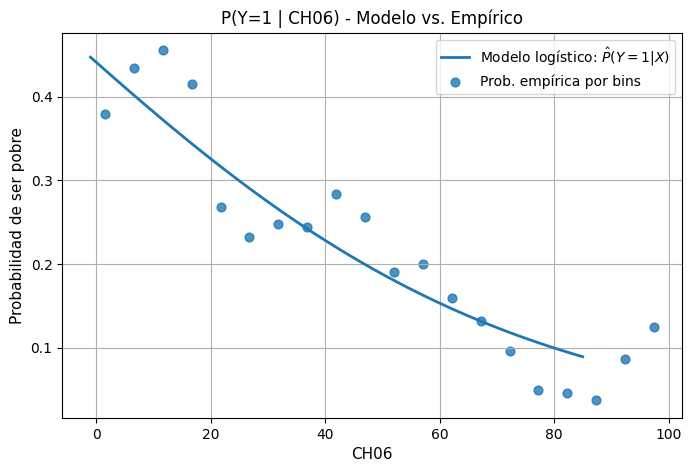

Comentario breve: En promedio, la curva del modelo es decreciente (pendiente media ≈ -0.0042 prob./unidad de CH06).
Interpretación sugerida: a medida que aumenta la característica en el eje X, la probabilidad estimada de ser pobre tende a disminuir. Contrastá la línea del modelo con los puntos empíricos para evaluar ajuste y posibles no linealidades.


In [7]:
#Elegí la característica numérica para el eje X
#    Por defecto usamos edad (CH06). Si no existe, toma la primera de vars_numericas.
feature_name = 'CH06'  # edad
if feature_name not in X.columns:
    if 'NIVEL_ED' in X.columns:
        feature_name = 'NIVEL_ED'
    else:
        # fallback: primera numérica disponible
        num_candidates = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
        if not num_candidates:
            raise ValueError("No hay variables numéricas disponibles para graficar.")
        feature_name = num_candidates[0]

print(f"Variable numérica seleccionada para el eje X: {feature_name}")

#Armamos una grilla de valores "razonables" para esa variable (entre p1 y p99)
x_min = np.nanpercentile(X[feature_name], 1)
x_max = np.nanpercentile(X[feature_name], 99)
x_grid = np.linspace(x_min, x_max, 60)

#Predicción del modelo logístico: P(Y=1|X) variando solo 'feature_name'
#    Mantenemos el resto de covariables en sus medias (PDP simple/partial dependence)
#    Nota: X_train fue el diseño sin constante; res es el modelo ya ajustado.
X_means = X_train.mean(numeric_only=True)
# Aseguramos que todas las columnas del train estén (por si hubo drops previos)
base = pd.DataFrame([X_means.values], columns=X_means.index)

pred_rows = []
for val in x_grid:
    row = base.copy()
    # si por algún motivo feature_name no estaba en TRAIN (lo agregamos con 0 y luego seteamos)
    if feature_name not in row.columns:
        row[feature_name] = 0.0
        # reordenamos columnas a como están en X_means + esta nueva
        row = row.reindex(columns=list(X_means.index) + [feature_name], fill_value=0.0)
        # y volvemos a alinear al orden de columnas de X_train
        row = row[X_train.columns.intersection(row.columns)]
        # si faltan columnas respecto de X_train, las completamos con 0
        for c in X_train.columns:
            if c not in row.columns:
                row[c] = 0.0
        row = row[X_train.columns]

    row[feature_name] = val
    pred_rows.append(row)

X_pred = pd.concat(pred_rows, ignore_index=True)

# Agregamos constante como en el entrenamiento
X_pred_const = sm.add_constant(X_pred, has_constant="add")

# Predicción de probabilidades
p_hat = res.predict(X_pred_const)

#Curva empírica (opcional pero útil): prob. observada por bins de la variable
#    Usamos XY (unido y limpio) que ya tenías del Ej3
bins = 20
cut = pd.cut(XY[feature_name], bins=bins)
emp = XY.groupby(cut)['POBRE'].mean().reset_index()
emp_x = emp[feature_name].apply(lambda x: 0.5*(x.left + x.right)).values
emp_y = emp['POBRE'].values

#Plot
plt.figure(figsize=(8,5))
plt.plot(x_grid, p_hat, label='Modelo logístico: $\hat{P}(Y=1|X)$', linewidth=2)
plt.scatter(emp_x, emp_y, s=40, alpha=0.8, label='Prob. empírica por bins')
plt.xlabel(feature_name)
plt.ylabel('Probabilidad de ser pobre')
plt.title(f'P(Y=1 | {feature_name}) - Modelo vs. Empírico')
plt.legend()
plt.grid(True)
plt.show()

#Mini-comentario automático (pendiente local promedio)
#    Calculamos diferencia promedio de prob por Δx para dar una idea del gradiente
dx = np.diff(x_grid)
dp = np.diff(p_hat)
slope_avg = np.nanmean(dp / dx)
trend = "creciente" if slope_avg > 0 else ("decreciente" if slope_avg < 0 else "plana")
print(f"Comentario breve: En promedio, la curva del modelo es {trend} (pendiente media ≈ {slope_avg:.4f} prob./unidad de {feature_name}).")
print("Interpretación sugerida: a medida que aumenta la característica en el eje X, la probabilidad estimada de ser pobre "
      "tende a " + ("aumentar" if slope_avg > 0 else ("disminuir" if slope_avg < 0 else "mantenerse relativamente constante")) +
      ". Contrastá la línea del modelo con los puntos empíricos para evaluar ajuste y posibles no linealidades.")

C. Método de Vecinos Cercanos (KNN)

5. Estimación: Clasifiquen a las observaciones como “pobre”/“no pobre” en su región con Vecinos Cercanos (KNN) usando K={1,5,10} para su matriz X_train.. Expliquen en no más de 2-3 oraciones como la elección de K se relaciona con el trade-off sesgo varianza.

In [8]:
#Base CH06 + IPCF + target
assert {'CH06','IPCF','POBRE'}.issubset(respondieron.columns), "Faltan CH06/IPCF/POBRE"
df = respondieron[['CH06','IPCF','POBRE']].copy()
df['CH06'] = pd.to_numeric(df['CH06'], errors='coerce')
df['IPCF'] = pd.to_numeric(df['IPCF'], errors='coerce')
df['IPCF_log'] = np.log1p(df['IPCF'])

X = df[['CH06','IPCF_log']]
y = df['POBRE'].astype(int)

#Split 70/30 estratificado
X_train_knn, X_test_knn, y_train, y_test = train_test_split(
    X, y, train_size=0.70, random_state=444, stratify=y
)

#Pipeline: imputación + escala + KNN
def evaluar_knn(k):
    pipe = Pipeline([
        ("imp",  SimpleImputer(strategy="median")),
        ("scal", StandardScaler()),
        ("knn",  KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train_knn, y_train)
    y_pred = pipe.predict(X_test_knn)
    return {
        "K": k,
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall":    recall_score(y_test, y_pred),
        "F1":        f1_score(y_test, y_pred)
    }

tabla_knn = pd.DataFrame([evaluar_knn(k) for k in [1,5,10]]).sort_values("K").round(3)
display(tabla_knn)

,K,Accuracy,Precision,Recall,F1
0,1,0.965,0.927,0.949,0.938
1,5,0.967,0.939,0.943,0.941
2,10,0.969,0.957,0.930,0.944


6. Visualización: Grafiquen dos características numéricas en su matriz X_train y visualicen las clases predichas por KNN usando con K={1,5,10} con su frontera por clase “pobre”/“no pobre”. (Hint: revisar Tutorial 8)

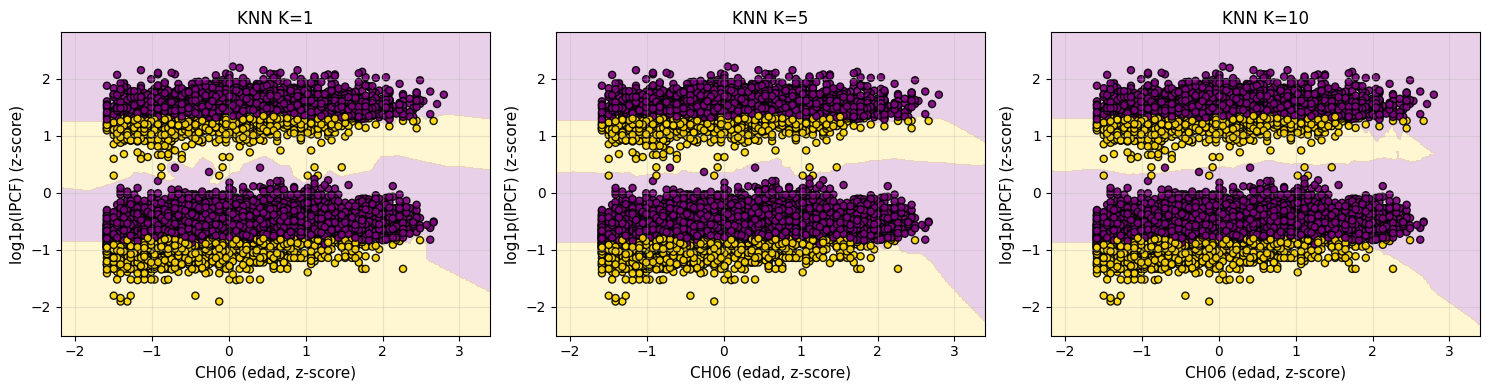

In [9]:
#Usar X_train_knn/y_train si existen; si no, construirlos desde `respondieron`
X_train_src = X_train_knn.copy()
y_train_src = y_train.copy()

#Imputación (mediana)
Xtr_vis = X_train_src[['CH06','IPCF_log']].copy()
imp = SimpleImputer(strategy='median').fit(Xtr_vis)
Xtr_vis = pd.DataFrame(imp.transform(Xtr_vis), columns=['CH06','IPCF_log'])

#Estandarización z-score
sc = StandardScaler().fit(Xtr_vis)
Xtr_s = sc.transform(Xtr_vis)
ytr = np.asarray(y_train_src, dtype=int)

#Grilla 2D para la frontera
x_min, x_max = Xtr_s[:,0].min()-0.6, Xtr_s[:,0].max()+0.6
y_min, y_max = Xtr_s[:,1].min()-0.6, Xtr_s[:,1].max()+0.6
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

#Graficar fronteras para K={1,5,10}
cmap_pts = ListedColormap(["purple","gold"])
plt.figure(figsize=(15,4))

for i, k in enumerate([1,5,10], start=1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(Xtr_s, ytr)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax = plt.subplot(1,3,i)
    ax.contourf(xx, yy, Z, alpha=0.18, levels=[-0.5,0.5,1.5], colors=["purple","gold"])
    ax.scatter(Xtr_s[:,0], Xtr_s[:,1], c=ytr, cmap=cmap_pts,
               edgecolor="k", s=26, alpha=0.9)
    ax.set_title(f"KNN K={k}")
    ax.set_xlabel("CH06 (edad, z-score)")
    ax.set_ylabel("log1p(IPCF) (z-score)")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

7. Para obtener el K óptimo usando Cross-Validation, dividiendo la base de respondieron_2025 en 5 partes. Muestren cómo eligen el óptimo a través del gráfico visto en la tutorial sobre Accuracy en cada K. Llamenle a este modelo KNN con K-CV.

K óptimo (5-fold CV, 2025): 15 — Accuracy promedio = 0.975 (±0.005)


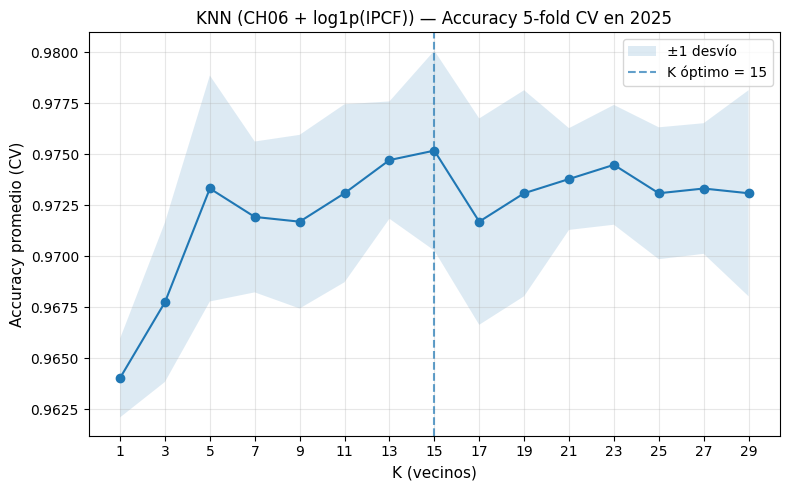

Modelo final entrenado: knn_kcv_2025 (usa columnas ['CH06','IPCF_log']).


In [10]:
#Subconjunto 2025 si existe ANIO; si no, usar todo y avisar
df25 = respondieron.loc[respondieron['ANIO']==2025, ['CH06','IPCF','POBRE']].copy()

df25['CH06'] = pd.to_numeric(df25['CH06'], errors='coerce')
df25['IPCF'] = pd.to_numeric(df25['IPCF'], errors='coerce')
df25['IPCF_log'] = np.log1p(df25['IPCF'])

X25 = df25[['CH06','IPCF_log']]
y25 = df25['POBRE'].astype(int)

#Pipeline dentro de cada fold
def make_pipe(k):
    return Pipeline([
        ("imp",  SimpleImputer(strategy="median")),
        ("scal", StandardScaler()),
        ("knn",  KNeighborsClassifier(n_neighbors=k))
    ])

#Grilla de K y CV
Ks = list(range(1, 31, 2))   # impares 1..29
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)

acc_mean, acc_std = [], []
for k in Ks:
    pipe = make_pipe(k)
    scores = cross_val_score(pipe, X25, y25, cv=cv, scoring="accuracy")
    acc_mean.append(scores.mean()); acc_std.append(scores.std())

acc_mean = np.array(acc_mean); acc_std = np.array(acc_std)
k_opt = Ks[int(acc_mean.argmax())]
print(f"K óptimo (5-fold CV, 2025): {k_opt} — Accuracy promedio = {acc_mean.max():.3f} (±{acc_std[acc_mean.argmax()]:.3f})")

#Gráfico Accuracy vs K
plt.figure(figsize=(8,5))
plt.plot(Ks, acc_mean, marker="o")
plt.fill_between(Ks, acc_mean-acc_std, acc_mean+acc_std, alpha=0.15, label="±1 desvío")
plt.axvline(k_opt, linestyle="--", alpha=0.7, label=f"K óptimo = {k_opt}")
plt.title("KNN (CH06 + log1p(IPCF)) — Accuracy 5-fold CV en 2025")
plt.xlabel("K (vecinos)"); plt.ylabel("Accuracy promedio (CV)")
plt.xticks(Ks); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

#Modelo final entrenado con K óptimo (KNN con K-CV)
knn_kcv_2025 = make_pipe(k_opt)
knn_kcv_2025.fit(X25, y25)
print("Modelo final entrenado: knn_kcv_2025 (usa columnas ['CH06','IPCF_log']).")


D. Desempeño de modelos, elección y predicción afuera de la muestra

8. Comparen el desempeño de predicción de pobreza en la base de testeo del modelo Logit y KNN con K-CV. Muestren la matriz de confusión (con umbral p>0.5), la curva ROC de ambos modelos, y dos métricas más vista en clase e interprete los resultados.


>>> LOGIT
Accuracy=0.715 | Precision=0.460 | Recall(Sens.)=0.188 | F1=0.267
Specificity=0.916 | Balanced Acc=0.552 | ROC-AUC=0.704


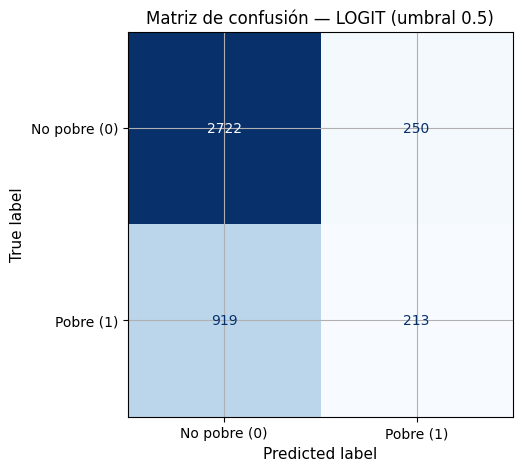


>>> KNN (K=15)
Accuracy=0.968 | Precision=0.946 | Recall(Sens.)=0.936 | F1=0.941
Specificity=0.980 | Balanced Acc=0.958 | ROC-AUC=0.995


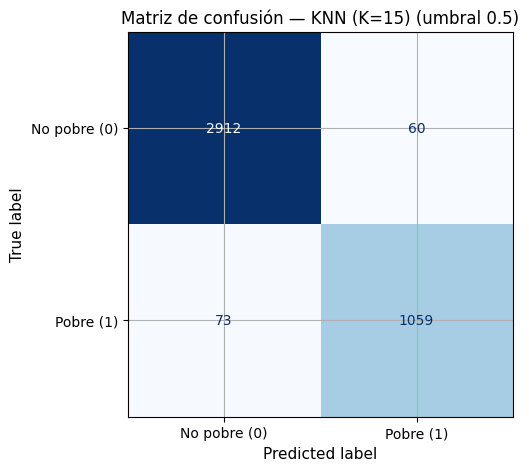

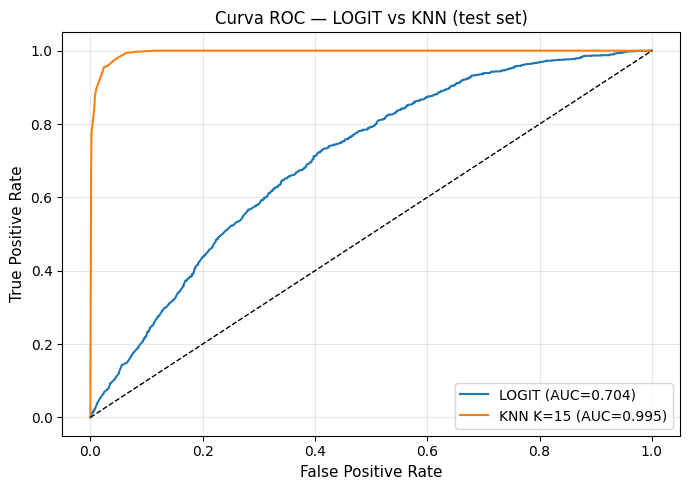

In [11]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)

def resumen_metricas(y_true, y_score, nombre="modelo", umbral=0.5):
    y_pred = (y_score >= umbral).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_score)
    spec = tn / (tn + fp)  # especificidad
    bal_acc = (rec + spec) / 2  # exactitud balanceada

    print(f"\n>>> {nombre}")
    print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall(Sens.)={rec:.3f} | F1={f1:.3f}")
    print(f"Specificity={spec:.3f} | Balanced Acc={bal_acc:.3f} | ROC-AUC={auc:.3f}")

    ConfusionMatrixDisplay(cm, display_labels=["No pobre (0)","Pobre (1)"])\
        .plot(cmap="Blues", colorbar=False, values_format="d")
    plt.title(f"Matriz de confusión — {nombre} (umbral 0.5)")
    plt.show()

    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auc":auc,
            "spec":spec,"bal_acc":bal_acc}

# LOGIT
import statsmodels.api as sm
X_test_const = sm.add_constant(X_test, has_constant="add")
y_score_logit = res.predict(X_test_const)
met_logit = resumen_metricas(y_test.values.astype(int), y_score_logit.values, nombre="LOGIT")

#KNN K-CV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

if 'k_opt' not in globals():
    k_opt = 15
pipe_knn = Pipeline([
    ("imp",  SimpleImputer(strategy="median")),
    ("scal", StandardScaler()),
    ("knn",  KNeighborsClassifier(n_neighbors=k_opt))
]).fit(X_train_knn[['CH06','IPCF_log']], y_train)
y_score_knn = pipe_knn.predict_proba(X_test_knn[['CH06','IPCF_log']])[:,1]
met_knn = resumen_metricas(y_test.values.astype(int), y_score_knn, nombre=f"KNN (K={k_opt})")

#Curva ROC comparativa
fpr_l, tpr_l, _ = roc_curve(y_test.values.astype(int), y_score_logit.values)
fpr_k, tpr_k, _ = roc_curve(y_test.values.astype(int), y_score_knn)
plt.figure(figsize=(7,5))
plt.plot(fpr_l, tpr_l, label=f"LOGIT (AUC={met_logit['auc']:.3f})")
plt.plot(fpr_k, tpr_k, label=f"KNN K={k_opt} (AUC={met_knn['auc']:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Curva ROC — LOGIT vs KNN (test set)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


9. Suponga que el Ministerio de Capital Humano esta interesado en identificar a grupos vulnerables para dirigir los recursos de un programa de alimentos. Discutan cuál modelo de clasificación es “mejor” para predecir pobres y asignar dichos recursos escasos. (Hint: recuerden que en la clase magistral discutimos el trade-off de minimizar error tipo I o II)

In [12]:
#Ajuste del umbral para política pública
from sklearn.metrics import classification_report

# Predicciones de probabilidad del modelo Logit
y_prob_logit = res.predict(sm.add_constant(X_test, has_constant="add"))

for umbral in [0.5, 0.4, 0.3]:
    y_pred_adj = (y_prob_logit >= umbral).astype(int)
    print(f"\n=== LOGIT con umbral {umbral} ===")
    print(classification_report(y_test, y_pred_adj, target_names=["No pobre (0)", "Pobre (1)"]))


=== LOGIT con umbral 0.5 ===
              precision    recall  f1-score   support

No pobre (0)       0.75      0.92      0.82      2972
   Pobre (1)       0.46      0.19      0.27      1132

    accuracy                           0.72      4104
   macro avg       0.60      0.55      0.55      4104
weighted avg       0.67      0.72      0.67      4104


=== LOGIT con umbral 0.4 ===
              precision    recall  f1-score   support

No pobre (0)       0.77      0.84      0.80      2972
   Pobre (1)       0.45      0.35      0.39      1132

    accuracy                           0.70      4104
   macro avg       0.61      0.59      0.60      4104
weighted avg       0.68      0.70      0.69      4104


=== LOGIT con umbral 0.3 ===
              precision    recall  f1-score   support

No pobre (0)       0.82      0.70      0.75      2972
   Pobre (1)       0.43      0.59      0.49      1132

    accuracy                           0.67      4104
   macro avg       0.62      0.64     

10. Con el método que seleccionaron, predigan qué personas son pobres dentro de la base norespondieron para 2025. ¿Qué proporción de las personas que no respondieron pudieron identificar como pobres?

In [13]:
#Variables que el modelo Logit utilizó en entrenamiento
vars_usadas = X_train.columns.tolist()
noresp_vars = [v for v in vars_usadas if v in norespondieron_2025.columns]

#Construcción de la matriz X_noresp
X_noresp = norespondieron_2025[noresp_vars].copy()
X_noresp = X_noresp.apply(pd.to_numeric, errors='coerce')

# Imputamos valores faltantes con la media de entrenamiento (aproximación conservadora)
X_noresp = X_noresp.fillna(X_train.mean())

#Agregar constante como en el modelo Logit original
X_noresp_const = sm.add_constant(X_noresp, has_constant="add")

#Predicción de probabilidad de pobreza
noresp_pred_prob = res.predict(X_noresp_const)

#Clasificación con el umbral óptimo elegido (0.3)
umbral_opt = 0.3
noresp_pred = (noresp_pred_prob >= umbral_opt).astype(int)

#Proporción total de personas clasificadas como pobres
prop_pobres = noresp_pred.mean() * 100
print(f"\nProporción de personas clasificadas como pobres en norespondieron_2025: {prop_pobres:.2f}%")

#(Opcional) Distribución por deciles de probabilidad
noresp_df = pd.DataFrame({
    "prob_pobre": noresp_pred_prob,
    "pred_pobre": noresp_pred
})
noresp_df["decile"] = pd.qcut(noresp_df["prob_pobre"], 10, labels=False) + 1

tabla_deciles = (
    noresp_df.groupby("decile")
    .agg(n=("pred_pobre", "count"), pct_pobres=("pred_pobre", "mean"))
    .reset_index()
)
display(tabla_deciles.round(3))


Proporción de personas clasificadas como pobres en norespondieron_2025: 27.12%


,decile,n,pct_pobres
0,1,288,0.000
1,2,287,0.000
2,3,289,0.000
3,4,285,0.000
4,5,289,0.000
5,6,285,0.000
6,7,287,0.000
7,8,287,0.711
8,9,291,1.000
9,10,284,1.000
